# Import Data - 2 
In this example we see the power of scripting over Excel in that, once we have code for one site, it's fairly easy to repeat the code for many sites.

In [49]:
#Import libraries
import requests, io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [57]:
#Generate a list of all sites in NC using the NWIS API 
# see https://waterservices.usgs.gov/rest/DV-Service.html
url = 'http://waterservices.usgs.gov/nwis/site'
params = {'stateCd':'NC',        #NC Sites Only
          'siteStatus':'active', #Get all *active* sites
          'siteType':'ST',       #Stream sites only
          'parameterCd':'00060', #DISCHARGE(cfs), see https://help.waterdata.usgs.gov/codes-and-parameters/parameters
          'format':'rdb'         #RDB (csv)
         }

In [58]:
#Send the requests and translate the response
response_raw = requests.get(url,params)

In [59]:
#Decode to remove any odd characters (accents, etc.)
response_clean = response_raw.content.decode('utf-8')

In [60]:
#Build a list of line numbers to skip from comments and data types
rowsToSkip= [] #Create an empty list to hold line numbers
lineNumber = 0 #Initialize a line number variable
#Iterate through lines, adding the line number to the list for comment lines
for lineNumber, lineString in enumerate(response_clean.split("\n")):
    if lineString.startswith('#'): 
        rowsToSkip.append(lineNumber)
    else:
        break
#Add another line 2 greater than the last
dataTypeLineNumber = rowsToSkip[-1] + 2
rowsToSkip.append(dataTypeLineNumber)

In [61]:
#Convert the data into a data frame
df = pd.read_csv(io.StringIO(response_clean),
                 skiprows=rowsToSkip,     #Skip metadta and data spec lines
                 delimiter='\t',          #Set to tab delimited
                 dtype={'site_no':'str',  #Set site_no to a string datatype
                        'huc_cd':'str'})  #Set huc_cd to a string datatype
 
#Print the number of returned sites
df.head()

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd
0,USGS,0204382800,"PASQUOTANK RIVER NEAR SOUTH MILLS, NC",ST,36.421389,-76.342500,S,NAD83,-5.50,0.11,NAVD88,03010205
1,USGS,02053200,"POTECASI CREEK NEAR UNION, NC",ST,36.370833,-77.025556,S,NAD83,3.53,0.01,NGVD29,03010204
2,USGS,02053500,"AHOSKIE CREEK AT AHOSKIE, NC",ST,36.280278,-76.999444,S,NAD83,17.46,0.01,NGVD29,03010203
3,USGS,02068500,"DAN RIVER NEAR FRANCISCO, NC",ST,36.515000,-80.303056,S,NAD83,831.99,0.01,NGVD29,03010103
4,USGS,02069000,"DAN RIVER AT PINE HALL, NC",ST,36.319303,-80.050042,S,NAD83,563.70,0.33,NAVD88,03010103


In [7]:
from folium.plugins import MarkerCluster
from folium import FeatureGroup, LayerControl, Map, Marker

In [8]:
#Create the initial map
m = folium.Map(location=[36,-80],zoom_start=8,tiles='Mapbox Bright')

#Loop through all features and add them to the map
for row in df.itertuples():
    #Get info for the record
    lat = row.dec_lat_va
    lng = row.dec_long_va
    name = row.station_nm
    #Create the marker object
    folium.features.CircleMarker(location=[lat,lng],
                                 color='red',
                                 fill=True,
                                 fill_opacity=0.6,
                                 radius=3,
                                 stroke=False).add_to(m)
#Show the map
m

In [9]:
#Save the file
m.save("foo.html")

In [10]:
import webbrowser
webbrowser.open_new_tab("foo.html")

True

## Show plots for a subset of points

In [62]:
#Subset records in Upper Neuse watershed (HUC8 = 03020201)
dfUpperNeuse = df[df['huc_cd'] == '03020201']
#List the unique site names are contained here
dfUpperNeuse['station_nm'].unique()

array(['ENO RIVER AT HILLSBOROUGH, NC', 'ENO RIVER NEAR DURHAM, NC',
       'LITTLE RIVER AT SR1461 NEAR ORANGE FACTORY, NC',
       'MOUNTAIN CREEK AT SR1617 NR BAHAMA, NC',
       'LITTLE R BL LITTLE R TRIB AT FAIRNTOSH, NC',
       'FLAT RIVER AT BAHAMA, NC', 'FLAT RIVER AT DAM NEAR BAHAMA, NC',
       'KNAP OF REEDS CREEK NEAR BUTNER, NC',
       'ELLERBE CREEK AT CLUB BOULEVARD AT DURHAM, NC',
       'ELLERBE CREEK NEAR GORMAN, NC', 'NEUSE RIVER NEAR FALLS, NC',
       'CRABTREE CR AT EBENEZER CHURCH RD NR RALEIGH, NC',
       'CRABTREE CREEK AT HWY 70 AT RALEIGH, NC',
       'CRABTREE CR AT OLD WAKE FOREST RD AT RALEIGH, NC',
       'CRABTREE CREEK AT US 1 AT RALEIGH, NC',
       'PIGEON HOUSE CR AT CAMERON VILLAGE AT RALEIGH, NC',
       'MARSH CREEK NEAR NEW HOPE, NC',
       'ROCKY BRANCH BELOW PULLEN DRIVE AT RALEIGH, NC',
       'WALNUT CREEK AT SUNNYBROOK DRIVE NR RALEIGH, NC',
       'NEUSE RIVER NEAR CLAYTON, NC', 'NEUSE RIVER AT SMITHFIELD, NC',
       'SWIFT CREEK NEAR 

In [71]:
#Make a list of site numbers
siteNumbers = dfUpperNeuse['site_no'].unique().tolist()
print(siteNumbers)

['02085000', '02085070', '0208521324', '0208524090', '0208524975', '02085500', '02086500', '02086624', '0208675010', '02086849', '02087183', '0208726005', '02087275', '02087322', '02087324', '0208732534', '0208732885', '0208735012', '02087359', '02087500', '02087570', '02087580', '0208758850', '0208773375', '02088000', '02088383', '02088500']


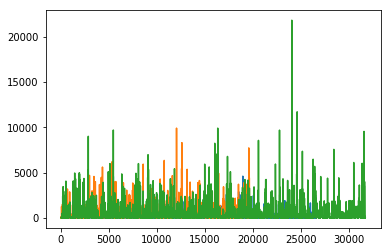

In [84]:
fig, ax = plt.subplots()
#Define a function to retreieve discharge data for each
for siteNo in siteNumbers[:6]:
    if len(siteNo) > 8: continue
    #Construct the service URL and parameters
    url =  'https://waterservices.usgs.gov/nwis/dv'
    params = {'sites':siteNo,
              'parameterCd':'00060',
              'statCd':'00003',
              'startDT':'1930-10-01',
              'endDT':'2017-09-03',
              'format':'rdb',
              'siteStatus':'all'
             }
    response_raw =  requests.get(url,params)
    response_clean =response_raw.content.decode('utf-8')
    #Convert the data into a data frame
    #rowsToSkip = list(range(28))
    #rowsToSkip.append(29)
    
    #Build a list of line numbers to skip from comments and data types
    rowsToSkip= [] #Create an empty list to hold line numbers
    lineNumber = 0 #Initialize a line number variable
    #Iterate through lines, adding the line number to the list for comment lines
    for lineNumber, lineString in enumerate(response_clean.split("\n")):
        if lineString.startswith('#'): 
            rowsToSkip.append(lineNumber)
        else:
            break
    #Add another line 2 greater than the last
    dataTypeLineNumber = rowsToSkip[-1] + 2
    rowsToSkip.append(dataTypeLineNumber)
    
    #Create a dataframe from the downloaded data
    dfSite = pd.read_csv(io.StringIO(response_clean),
                         skiprows=rowsToSkip,
                         delimiter='\t',
                         dtype={'site_no':'str'})

    #Rename the columns
    dfSite.columns = ['agency_cd','site_no','datetime','meanflow_cfs','confidence']

    #plot the flow
    #dfSite['meanflow_cfs'].plot(figsize=(20,6))
    ax.plot(dfSite['meanflow_cfs'])

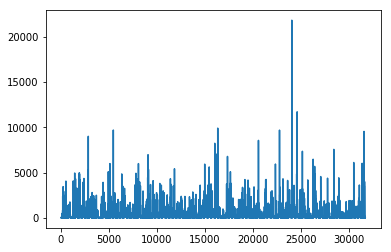

In [83]:
fig, ax = plt.subplots()
ax.plot(dfSite['meanflow_cfs'])